# Paint with Perceptron
A Perceptron trained with the MNIST dataset will be able to recognize pictures with digits. 
Using it, I want to create a Paint, which can recognize digits.

Used: 
- MNIST dataset
- Tensorflow 
- JupyterLab
- Pandas
- Matplotlib
- Seaborn

Import libs:

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import layers

import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

tf.version.VERSION

c:\Projects\PaintWithPerceptron\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'2.15.0'

## Load and split dataset
Load MNIST dataset from *tensorflow-datasets*. Split it and shuffle the data. 
`as_supervised=True` for get a tuple insted dictionary.

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
);

## Build a training pipeline

Apply the following transformations:

- `tf.data.Dataset.map`: TFDS provide images of type `tf.uint8`, while the model expects `tf.float32`. Therefore, I need to normalize images.
- `tf.data.Dataset.cache`: Cache it before shuffling for a better performance.
- `tf.data.Dataset.shuffle`: For true randomness, set the shuffle buffer to the full dataset size.
- `tf.data.Dataset.batch`: Batch elements of the dataset after shuffling to get unique batches at each epoch.
- `tf.data.Dataset.prefetch`: The end of transformations pipline.

In [3]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label


ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

## Build a test pipeline

Test transformation pipline is similar to the training once, but with small difference.

- Don't need to use `shuffle`
- Caching is done after batching.

In [4]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE
)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Visualise data
The MNIST dataset consists of handwritten digits and their corresponding true labels. Visualize a couple of examples below:

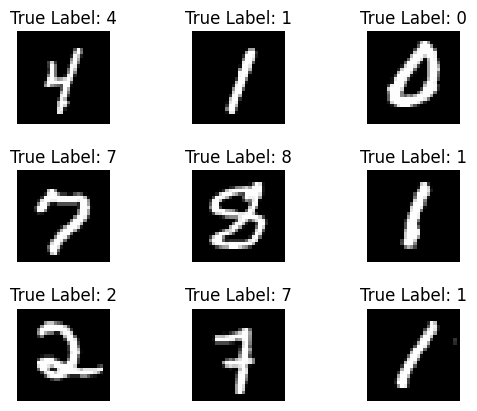

In [12]:
x_viz, y_viz = tfds.load(
    "mnist", split=['train[:1500]'], batch_size=-1, as_supervised=True
)[0]
x_viz = tf.squeeze(x_viz, axis=3)

for i in range(9):
    plt.subplot(3, 3, 1+i)
    plt.axis('off')
    plt.imshow(x_viz[i], cmap='gray')
    plt.title(f"True Label: {y_viz[i]}")
    plt.subplots_adjust(hspace=.5)

### And the diagram:

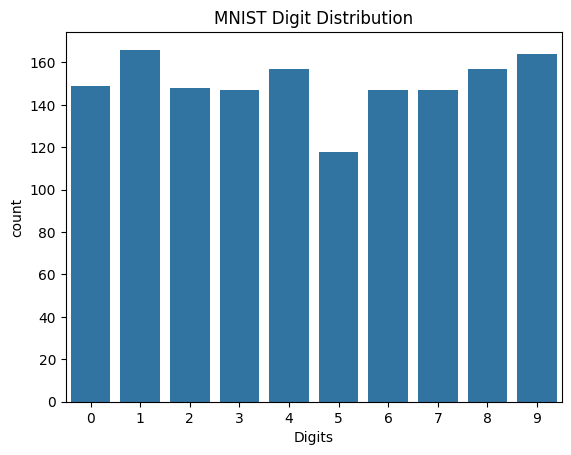

In [14]:
sns.countplot(x=y_viz.numpy())
plt.xlabel('Digits')
plt.title("MNIST Digit Distribution");

## Create and train model
Input pipeline into keras model:

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
]);

Compile the model:

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
);

Fit the model with train data:

In [21]:
model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
);

Epoch 1/6


469/469 [==============================] - 1s 2ms/step - loss: 0.0504 - sparse_categorical_accuracy: 0.9858 - val_loss: 0.0754 - val_sparse_categorical_accuracy: 0.9762
Epoch 2/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0434 - sparse_categorical_accuracy: 0.9875 - val_loss: 0.0725 - val_sparse_categorical_accuracy: 0.9765
Epoch 3/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0360 - sparse_categorical_accuracy: 0.9898 - val_loss: 0.0689 - val_sparse_categorical_accuracy: 0.9784
Epoch 4/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0305 - sparse_categorical_accuracy: 0.9913 - val_loss: 0.0699 - val_sparse_categorical_accuracy: 0.9788
Epoch 5/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0252 - sparse_categorical_accuracy: 0.9936 - val_loss: 0.0665 - val_sparse_categorical_accuracy: 0.9802
Epoch 6/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0208 - sparse_categorical_accuracy: 0.99